# Cohérence spatio-temporelle

Nous souhaitons nous assurer que les données décrivent un même phénomène physique sur une grille spatiale et temporelle cohérente, et cela, en maintenant une continuité et une exploitabilité pour l’analyse et la modélisation.

## 1. Cohérence temporelle

### 1.1 Vérifier la structure du temps

In [65]:
import xarray as xr

dsNOAA = xr.open_dataset("data/raw/merged/sstNOAA20102019.nc", chunks={"time": 365})
dsCOPERNICUS = xr.open_dataset("data/raw/merged/sstCOPERNICUS20102019.nc", chunks={"time": 365})

print(dsNOAA.time)
print(dsNOAA.time.encoding)

print("\n***************************************\n")

print(dsCOPERNICUS.time)
print(dsCOPERNICUS.time.encoding)

<xarray.DataArray 'time' (time: 3652)> Size: 29kB
array(['2010-01-01T00:00:00.000000000', '2010-01-02T00:00:00.000000000',
       '2010-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      shape=(3652,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
Attributes:
    long_name:     Time
    delta_t:       0000-00-01 00:00:00
    avg_period:    0000-00-01 00:00:00
    axis:          T
    actual_range:  [76701. 77065.]
{'dtype': dtype('float64'), 'zlib': False, 'szip': False, 'zstd': False, 'bzip2': False, 'blosc': False, 'shuffle': False, 'complevel': 0, 'fletcher32': False, 'contiguous': True, 'chunksizes': None, 'source': '/home/mkkuu/Documents/GitHub/m1Project_SciML/data/raw/merged/sstNOAA20102019.nc', 'original_shape': (3652,), '_FillValue': np.float64(nan), 'units': 'days since 1800-01-01', 'calendar': 'proleptic_gregorian'}


/tmp/nix-shell.B72SES/ipykernel_9392/1414365808.py:3: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  dsNOAA = xr.open_dataset("data/raw/merged/sstNOAA20102019.nc", chunks={"time": 365})
/tmp/nix-shell.B72SES/ipykernel_9392/1414365808.py:4: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  dsCOPERNICUS = xr.open_dataset("data/raw/merged/sstCOPERNICUS20102019.nc", chunks={"time": 365})


En comparant les axes temporels des deux jeux de données, on constate un léger décalage de borne temporelle. Copernicus incluant un jour supplémentaire au-delà de l'année 2019. Pour garantir la cohérence temporelle stricte entre les sources, nous allons simplement restreindre le jeu de donnée COPERNICUS à la période commune 2010-2019.

On note également une différence de standard de calendrier, NOAA utilisant le calendrier grégorien proleptique et COPERNICUS le grégorien simple. Cela ne fait aucune différence pour les années suivant 1582 d'après nos recherches. Aucun traitement ne sera réalisé.

In [41]:
print(dsNOAA.time.equals(dsCOPERNICUS.time)) # False, confirmant l'inégalité des bornes temporelles

dsCOPERNICUS = dsCOPERNICUS.sel(time=slice("2010-01-01", "2019-12-31")) # We apply slicing to ensure the same time range

print(dsNOAA.time.equals(dsCOPERNICUS.time)) # We check again after slicing

print(dsCOPERNICUS.time) # We print the time coordinate after slicing

False
False
<xarray.DataArray 'time' (time: 3653)> Size: 29kB
array(['2010-01-01T00:00:00.000000000', '2010-01-02T00:00:00.000000000',
       '2010-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      shape=(3653,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T


### 1.2 Continuité temporelle

On constate toujours une inégalité entre le nombre de points temporels dans les deux jeux de données. Il semblerait qu'il y ait toujours un point temporel supplémentaire (nous voulons avoir 3652 points correspondant à 8 années à 365 jours et 2 années bissextiles à 366 jours, soit 3652 jours). Explorons l'hypothèse d'un éventuel doublon en vérifiant le pas de temps.

In [42]:
import pandas as pd

dtNOAA = pd.to_datetime(dsNOAA.time.values).to_series().diff().dropna().unique()
dtCOPERNICUS  = pd.to_datetime(dsCOPERNICUS.time.values).to_series().diff().dropna().unique()

# For each dataset :
#   - convert time values to pandas datetime
#   - convert it to a pandas Series to manipulate it easily
#   - compute the difference between each time value and the previous one
#   - drop the NaT value resulting from the diff operation
#   - get the unique values of the resulting time differences

print(dtNOAA, dtCOPERNICUS) # Print delta times for both datasets


<TimedeltaArray>
['1 days']
Length: 1, dtype: timedelta64[ns] <TimedeltaArray>
['1 days', '0 days']
Length: 2, dtype: timedelta64[ns]


Résultant de notre test, on constate bel et bien la présence d'un doublon dans le jeu de donnée COPERNICUS. Pourquoi ? Car on remarque la présence de l'élément '0 days' dans la liste en retour de notre opération, signifiant qu'il existe 2 points SST pour un jour.

In [43]:
time = pd.to_datetime(dsCOPERNICUS.time.values) # We instanciate a pandas datetime object from the time values of the COPERNICUS dataset
dt = time.to_series().diff() # We convert it to a pandas Series and compute the time differences between each value and the previous one

duplicates = dt[dt == pd.Timedelta(0)] # We filter the delta times to get only the duplicates of 0 timedelta
print(duplicates) 

idx = duplicates.index # We get the index corresponding to the duplicate time values so it returns us the days where there are duplicates
print(idx)

2015-01-01   0 days
dtype: timedelta64[ns]
DatetimeIndex(['2015-01-01'], dtype='datetime64[ns]', freq=None)


Le jour présent 2 fois est donc le 01 janvier 2015. En effet, ayant télécharger manuellement depuis le site officiel sur les bornes 01/01/2010-01/01/2015 puis dans un second temps 01/01/2015-01/01/2020, cela a généré un doublon à la fusion des deux fichiers.

In [44]:
import numpy as np

index = np.unique(dsCOPERNICUS.time, return_index=True)[1] # We get the unique time values and their corresponding indices
dsCOPERNICUS = dsCOPERNICUS.isel(time=index) # We select only the unique time values using their indices

print(pd.to_datetime(dsCOPERNICUS.time.values).to_series().diff().dropna().unique()) # We confirm there are no more duplicate time values by computing the delta times again
print(dsCOPERNICUS.time.equals(dsNOAA.time)) # We test the equality of the time bounds again after removing duplicates

<TimedeltaArray>
['1 days']
Length: 1, dtype: timedelta64[ns]
True


La comparaison sur les axes temporelles des 2 jeux de données retourne True. Nous présumons ainsi la cohérence temporelle vérifiée et les fichiers bien alignés temporellement.

## 2. Cohérence spatiale

### 2.1 Définition de la grille

In [45]:
print(dsNOAA.dims)
print(dsNOAA.lat.min(), dsNOAA.lat.max())
print(dsNOAA.lon.min(), dsNOAA.lon.max())

print("\n***************************************\n")

print(dsCOPERNICUS.dims)
print(dsCOPERNICUS.latitude.min(), dsCOPERNICUS.latitude.max())
print(dsCOPERNICUS.longitude.min(), dsCOPERNICUS.longitude.max())


FrozenMappingWarningOnValuesAccess({'time': 3652, 'lat': 28, 'lon': 12})
<xarray.DataArray 'lat' ()> Size: 4B
array(-1.875, dtype=float32)
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y <xarray.DataArray 'lat' ()> Size: 4B
array(4.875, dtype=float32)
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y
<xarray.DataArray 'lon' ()> Size: 4B
array(48.125, dtype=float32)
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    actual_range:   [1.25000e-01 3.59875e+02]
    axis:           X <xarray.DataArray 'lon' ()> Size: 4B
array(50.875, dtype=float32)
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    actual_range:   [1.25000e-01 3.59875e+02]
    axis:   

Première différence majeure constatée entre les deux de jeux de données : la résolution spatiale. En effet, on constate que NOAA possède une grille de 28 * 12 (latitude*longitude) points par jour, soit 336 points. Le jeu de donnée COPERNICUS va, quant à lui, posséder une grille de 60 * 140 points par jour, soit 8400 points.

### 2.2 Résolution spatiale

La résolution spatiale correspond à la distance minimale, exprimée en unités de carte (ici les degrés), qui sépare les valeurs x uniques ou les valeurs y uniques dans les coordonnées d'entité. Une résolution plus fine (plus petite valeur) permet une meilleure précision des coordonnées, mais peut entraîner une baisse des performances en raison d'une utilisation accrue du disque et d'un nombre plus élevé d'opérations d'E/S (pour entrée/sortie) ce qui entraîne souvent des périodes d'inactivités du CPU. Déterminons les résolutions des 2 jeux de données.

In [46]:
# We check spatial resolution for both datasets with the following method :
#   - compute the difference between each latitude/longitude value and the previous one
#   - compute the mean of these differences to get the average spatial resolution

# NOAA

latResNOAA = dsNOAA.lat.diff("lat").mean()
lonResNOAA = dsNOAA.lon.diff("lon").mean()
print(latResNOAA, lonResNOAA)

# COPERNICUS

latResCopernicus = dsCOPERNICUS.latitude.diff("latitude").mean()
lonResCopernicus = dsCOPERNICUS.longitude.diff("longitude").mean()
print(latResCopernicus, lonResCopernicus)


<xarray.DataArray 'lat' ()> Size: 4B
array(0.25, dtype=float32)
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y <xarray.DataArray 'lon' ()> Size: 4B
array(0.25, dtype=float32)
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    actual_range:   [1.25000e-01 3.59875e+02]
    axis:           X
<xarray.DataArray 'latitude' ()> Size: 4B
array(0.05000001, dtype=float32)
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    unit_long:      Degrees North
    axis:           Y <xarray.DataArray 'longitude' ()> Size: 4B
array(0.05, dtype=float32)
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    unit_long:      Degrees East
    axis:           X


Les résultats coïncident avec notre constat précédent, la résolution spatiale (équivalent au pas temporel pour les coordonnées géographiques) du jeu de donnée COPERNICUS est de 0.05° contre 0.25° pour NOAA, soit 5 fois supérieur. On ne peut pour le moment pas établir quelconques affirmations, cela pourrait simplement signifier que COPERNICUS a plus interpolé que NOAA ce qui se répercuterait sur l'apprentissage des modèles.

### 2.3 Orientation des axes

In [47]:
# We check how the latitude values are ordered (ascending or descending) for both datasets

print((dsNOAA.lat.diff("lat") > 0).all())
print((dsCOPERNICUS.latitude.diff("latitude") > 0).all()) 

# Same for longitude values

print((dsNOAA.lon.diff("lon") > 0).all())
print((dsCOPERNICUS.longitude.diff("longitude") > 0).all()) 


<xarray.DataArray 'lat' ()> Size: 1B
array(True)
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    actual_range:   [-89.875  89.875]
    axis:           Y
<xarray.DataArray 'latitude' ()> Size: 1B
array(True)
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    unit_long:      Degrees North
    axis:           Y
<xarray.DataArray 'lon' ()> Size: 1B
array(True)
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    actual_range:   [1.25000e-01 3.59875e+02]
    axis:           X
<xarray.DataArray 'longitude' ()> Size: 1B
array(True)
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    unit_long:      Degrees East
    axis:           X


Après vérification de l'orientation des axes, les tests réalisés indiquent que, pour les deux sources, les latitudes sont ordonnées de manière croissante, correspondant à une progression du Sud vers le Nord, les longitudes sont également croissantes, traduisant une orientation de l’Ouest vers l’Est. Cette convention est cohérente avec les standards usuels et ne nécessite aucune réorientation supplémentaire.

### 2.4 Stabilité de la grille dans le temps

Une information importante à vérifier est la stabilité de la grille en fonction du temps. L'idéal serait d'avoir une grille indépendante temporellement, soit une grille dont les points restent identiques d'un point temporel à l'autre. Déterminons si la grille est stable.

In [48]:
print(dsNOAA.isel(time=0).lat.equals(dsNOAA.isel(time=-1).lat)) # We check if latitude values are the same for the first and last time steps in NOAA dataset
print(dsCOPERNICUS.isel(time=0).latitude.equals(dsCOPERNICUS.isel(time=-1).latitude))


False
False


À première vue, le fait que les tests nous retournent False devrait affirmer que la grille est dépendant du temps. Or, l'égalité testée avec la méthode equals() réalise en réalité un test d'égalité stricte (mêmes valeurs, même dtype, mêmes attributs, même ordre et aucune tolérance numérique). Ce résultat peut donc venir de détails subtils (3.0000001° != 3°) et ne suffit pas à affirmer la dépendance temporelle. Réalisons quelques tests supplémentaires.

In [49]:
# Here we compare like the previous check but with a tolerance for floating point precision issues thanks to numpy allclose function

# NOAA

print(np.allclose(
    dsNOAA.isel(time=0).lat.values,
    dsNOAA.isel(time=-1).lat.values
))

print(np.allclose(
    dsNOAA.isel(time=0).lon.values,
    dsNOAA.isel(time=-1).lon.values
))

print("\n***************************************\n")

# COPERNICUS

print(np.allclose(
    dsCOPERNICUS.isel(time=0).latitude.values,
    dsCOPERNICUS.isel(time=-1).latitude.values
))

print(np.allclose(
    dsCOPERNICUS.isel(time=0).longitude.values,
    dsCOPERNICUS.isel(time=-1).longitude.values
))


True
True

***************************************

True
True


En ajoutant un degré de tolérance, notre test précédent retourne désormais True. Cherchons si de micro-variabilités sont bien les causes de l'échec du précédent test.

In [50]:
# NOAA

print(dsNOAA.isel(time=0).lat.attrs)
print(dsNOAA.isel(time=-1).lat.attrs)

print(dsNOAA.isel(time=0).lon.attrs)
print(dsNOAA.isel(time=-1).lon.attrs)

print("\n***************************************\n")

# COPERNICUS

print(dsCOPERNICUS.isel(time=0).latitude.attrs)
print(dsCOPERNICUS.isel(time=-1).latitude.attrs)

print(dsCOPERNICUS.isel(time=0).longitude.attrs)
print(dsCOPERNICUS.isel(time=-1).longitude.attrs)

{'long_name': 'Latitude', 'standard_name': 'latitude', 'units': 'degrees_north', 'actual_range': array([-89.875,  89.875], dtype=float32), 'axis': 'Y'}
{'long_name': 'Latitude', 'standard_name': 'latitude', 'units': 'degrees_north', 'actual_range': array([-89.875,  89.875], dtype=float32), 'axis': 'Y'}
{'long_name': 'Longitude', 'standard_name': 'longitude', 'units': 'degrees_east', 'actual_range': array([1.25000e-01, 3.59875e+02], dtype=float32), 'axis': 'X'}
{'long_name': 'Longitude', 'standard_name': 'longitude', 'units': 'degrees_east', 'actual_range': array([1.25000e-01, 3.59875e+02], dtype=float32), 'axis': 'X'}

***************************************

{'standard_name': 'latitude', 'long_name': 'Latitude', 'units': 'degrees_north', 'unit_long': 'Degrees North', 'axis': 'Y'}
{'standard_name': 'latitude', 'long_name': 'Latitude', 'units': 'degrees_north', 'unit_long': 'Degrees North', 'axis': 'Y'}
{'standard_name': 'longitude', 'long_name': 'Longitude', 'units': 'degrees_east', 'u

On constate une égalité stricte pour chacun des valeurs des dictionnaires d'attributs des jeux de données. On écarte donc la faute à un changement dans les attributs.

In [51]:

# Latitude dims

print(dsNOAA.lat.dims)
print(dsCOPERNICUS.latitude.dims)

print("\n***************************************\n")

# Longitude dims

print(dsNOAA.lon.dims)
print(dsCOPERNICUS.longitude.dims)


('lat',)
('latitude',)

***************************************

('lon',)
('longitude',)


Ce dernier test nous affirme que les dimensions de latitude et longitude dépendent uniquement d'elle-même et non du temps. On peut donc affirmer que la grille est indépendante temporellement et que la cause du premier échec est dû à des micro-variances de valeurs de latitude ou longitude pour un même point d'un temps t à t+x.

## 3. Cohérence spatio-temporelle conjointe

### 3.1 Identification de zones masquées

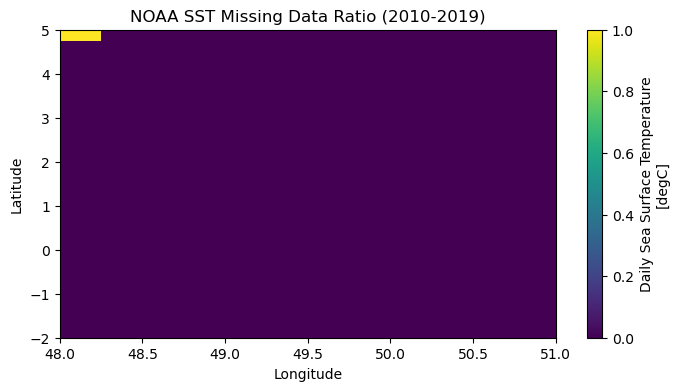

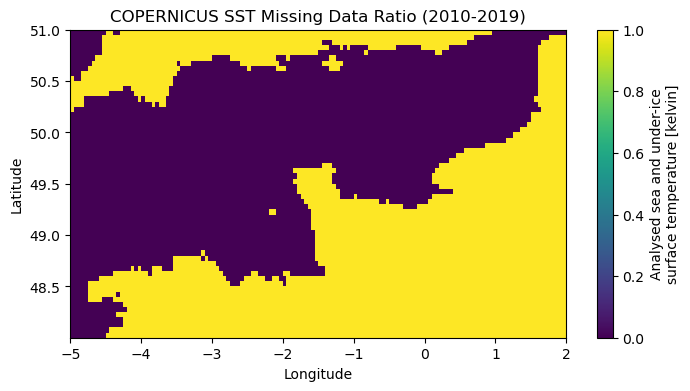

In [56]:
missingRatioNOAA = dsNOAA["sst"].isnull().mean(dim="time")
missingRatioCOPERNICUS = dsCOPERNICUS["analysed_sst"].isnull().mean(dim="time")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
missingRatioNOAA.plot(cmap="viridis")
plt.title("NOAA SST Missing Data Ratio (2010-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(8, 4))
missingRatioCOPERNICUS.plot(cmap="viridis")
plt.title("COPERNICUS SST Missing Data Ratio (2010-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

L’analyse du ratio de données manquantes met en évidence une différence structurelle entre les 2 jeux de données. Le jeu de donnée NOAA fournit un champ spatial complet (on note tout de même la présence d'une zone systématiquement manquante dans le coin supérieur gauche) résultant de méthodes d’interpolation et de reconstruction, y compris sur les zones terrestres. Le jeu de donnée Copernicus, lui, applique un masque terre/mer explicite, laissant apparaître les contours côtiers et excluant toute valeur sur les terres émergées. Afin de garantir une cohérence spatiale et une interprétation physique correcte, appliquons le masque océanique issu de Copernicus au jeu de donnée NOAA.

In [86]:
# We make sure xr open_dataset used chunks parameter to enable dask lazy loading when opening the datasets

maskOcean = ~dsCOPERNICUS["analysed_sst"].isel(time=0).isnull() # We only take a representative time step (the first one) to create the ocean mask so we avoid memory issues by using the entire time dimension

maskOcean = maskOcean.rename({ # We rename the dimensions to match those of the NOAA dataset and avoid multiple dimension errors when applying the mask
    "latitude": "lat",
    "longitude": "lon"
})

print(dsNOAA["sst"].data) # We verify that the data is still stored as dask arrays before applying the mask so we confirm we are working with lazy loading

dsNOAAMasked = dsNOAA.where(maskOcean) # Now we can apply the ocean mask only to the SST variable in the NOAA dataset

missingRatioNOAAMasked = (
    dsNOAAMasked["sst"]
    .isnull()
    .mean(dim="time")
)

print(missingRatioNOAAMasked.dims)

# plt.figure(figsize=(8, 4))
# missingRatioNOAAMasked.plot(cmap="viridis")
# plt.title("NOAA SST Missing Data Ratio after Ocean Masking (2010-2019)")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

# Returns a TypeError : No numeric data to plot.

dask.array<open_dataset-sst, shape=(3652, 28, 12), dtype=float32, chunksize=(365, 14, 6), chunktype=numpy.ndarray>
('lat', 'lon')
dask.array<where, shape=(3652, 0, 0), dtype=float32, chunksize=(365, 0, 0), chunktype=numpy.ndarray>


L’application directe du masque océanique fait à partir du jeu de donnée Copernicus au produit NOAA a conduit à une grille spatiale vide, en cause l’absence de correspondance exacte entre les points de grille des deux produits. Cette différence est liée, comme nous l'avons plus tôt, à des résolutions spatiales et des conventions de centrage distinctes. Par conséquence, aucune intersection spatiale n'est possible en l'état sans interpoler COPERNICUS sur NOA (ou un regrillage), une solution que nous écarterons par risque d'ajouter de l'incertitude. Les analyses ultérieures seront réalisés sur le jeu de données COPERNICUS pour profiter de la différenciation terre/océan.

### 3.2 Vérification de la cohérence globale

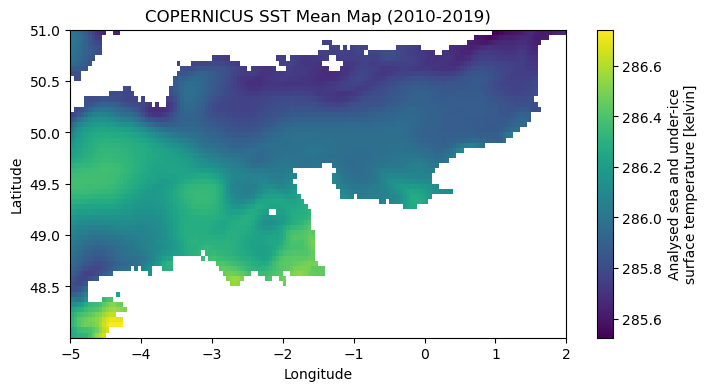

In [87]:
meanMapCOPERNICUS =dsCOPERNICUS["analysed_sst"].mean(dim="time")

plt.figure(figsize=(8, 4))
meanMapCOPERNICUS.plot(cmap="viridis")
plt.title("COPERNICUS SST Mean Map (2010-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Conclusion ?